# XGBoost

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [2]:
# Import dataset 
private_data = "../datasets/cleaned/cleaned_private.csv"

df = pd.read_csv(private_data, quotechar='"', escapechar='\\', thousands=',')
df

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Street Name,Type of Sale,Type of Area,Property Type,Number of Units,...,longitude,latitude,Price,Sale Year,Lease Duration,Lease Start Year,Remaining Lease Years,Distance to MRT (km),Sale Month-Year,Lease_Category
0,ONE BERNAM,2088000,807.30,2586,1/12/2022,BERNAM STREET,New Sale,Strata,Apartment,1,...,103.843685,1.273874,2088000,2022,99,2019.0,96,0.373974,2022-01,91-100 Years
1,RIVIERE,3390000,1140.98,2971,1/12/2022,JIAK KIM STREET,New Sale,Strata,Apartment,1,...,103.831584,1.284899,3390000,2022,99,2018.0,95,0.456742,2022-01,91-100 Years
2,RIVIERE,3780000,1216.33,3108,1/12/2022,JIAK KIM STREET,New Sale,Strata,Apartment,1,...,103.831584,1.284899,3780000,2022,99,2018.0,95,0.456742,2022-01,91-100 Years
3,LEEDON GREEN,1923000,710.42,2707,1/12/2022,LEEDON HEIGHTS,New Sale,Strata,Condominium,1,...,103.803546,1.313033,1923000,2022,999,2022.0,999,0.647571,2022-01,Freehold
4,LEEDON GREEN,1590000,538.20,2954,1/12/2022,LEEDON HEIGHTS,New Sale,Strata,Condominium,1,...,103.803546,1.313033,1590000,2022,999,2022.0,999,0.647571,2022-01,Freehold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128344,THE WHITLEY RESIDENCES,4998000,7190.35,695,1/3/2020,WHITLEY ROAD,Resale,Strata,Semi-Detached House,1,...,103.837373,1.325460,4998000,2020,999,NaN,999,0.907586,2020-01,Freehold
128345,WEST SHORE RESIDENCES,2850000,3982.68,716,1/3/2020,PASIR PANJANG ROAD,Resale,Strata,Terrace House,1,...,103.784856,1.281301,2850000,2020,999,NaN,999,0.327247,2020-01,Freehold
128346,ESTRIVILLAS,3180000,4703.87,676,1/3/2020,JALAN LIM TAI SEE,Resale,Strata,Semi-Detached House,1,...,103.793074,1.321131,3180000,2020,999,NaN,999,1.050407,2020-01,Freehold
128347,KEW RESIDENCIA,1570000,2142.04,733,1/3/2020,KEW CRESCENT,Resale,Strata,Terrace House,1,...,103.948504,1.317953,1570000,2020,99,1994.0,73,0.872140,2020-01,71-80 Years


In [4]:
# Preprocess data: Extract 'Sale Month-Year' from 'Sale Date'
df['Sale Month-Year'] = pd.to_datetime(df['Sale Date']).dt.to_period('M').astype(str)

# Remove price outliers using IQR method
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Reset index (optional if not filtering)
df.reset_index(drop=True, inplace=True)

# Select relevant columns
features = ['Area (SQFT)', 'Lease_Category', 'Property Type', 'Postal District',
            'Type of Sale', 'Floor Level', 'Sale Month-Year', 'Distance to MRT (km)']
target = 'Price'

# Encode categorical features
df_encoded = df[features + [target]].copy()
categorical_cols = ['Lease_Category', 'Property Type', 'Postal District', 
                    'Type of Sale', 'Floor Level', 'Sale Month-Year']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save if needed later

# Split into features and target
X = df_encoded[features]
y = df_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# Train XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=40)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

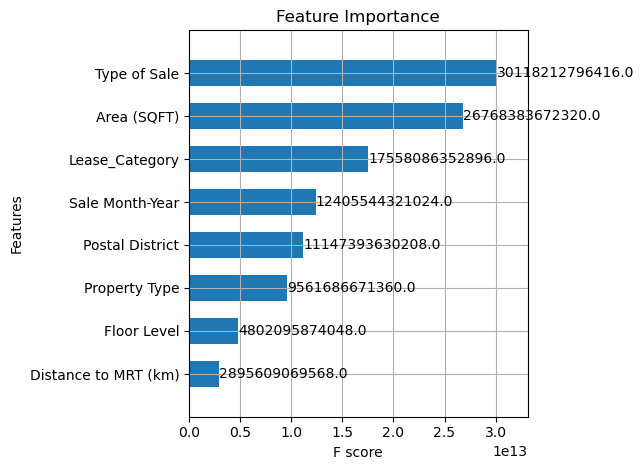

In [5]:
# Feature Importance Plot (which features XGBoost found most useful during training)
xgb.plot_importance(model, importance_type='gain', height=0.6)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

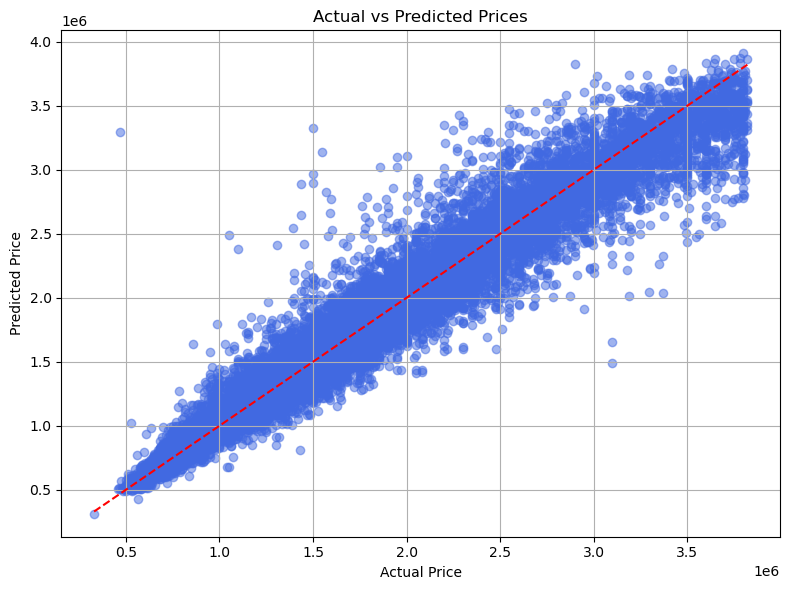

In [6]:
# Scatter Plot of Actual vs Predicted Prices (how close predictions are to the actual values)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Evaluate XGBoost model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error (MSE): 24470016620.15
Mean Absolute Error (MAE): 98851.68
R^2 Score: 0.9504
